# Provenance prediction from onshore to offshore
edited 18/9/2020 (original 11th November 2019 for AGU)

This notebook takes all GoM nonproprietary fossil data from onshore USA as a training set and predicts against a new well in offshore GoM from proprietary wells. The data are counts of fossil pollen, spores and phytoplankton from samples. Data are cleaned in previous stages and note presented due to confidentiality and then Hellinger transformed. Data focus on the Middle-Late Paleocene (60-55 Ma).

## Palynomorphs
These are fossil pollen and phytoplankton belonging to dinoflagellates (cysts). They range from 20-150 microns in size and are very abundant in the rock record. Different assemblages are used to fingerprint different rock ages and reservoirs in the offshore oil wells in many oil fields around the globe. This is just for interest! They are counted in samples and th data presented here are taxa (species) as columns and samples as rows from different depths.
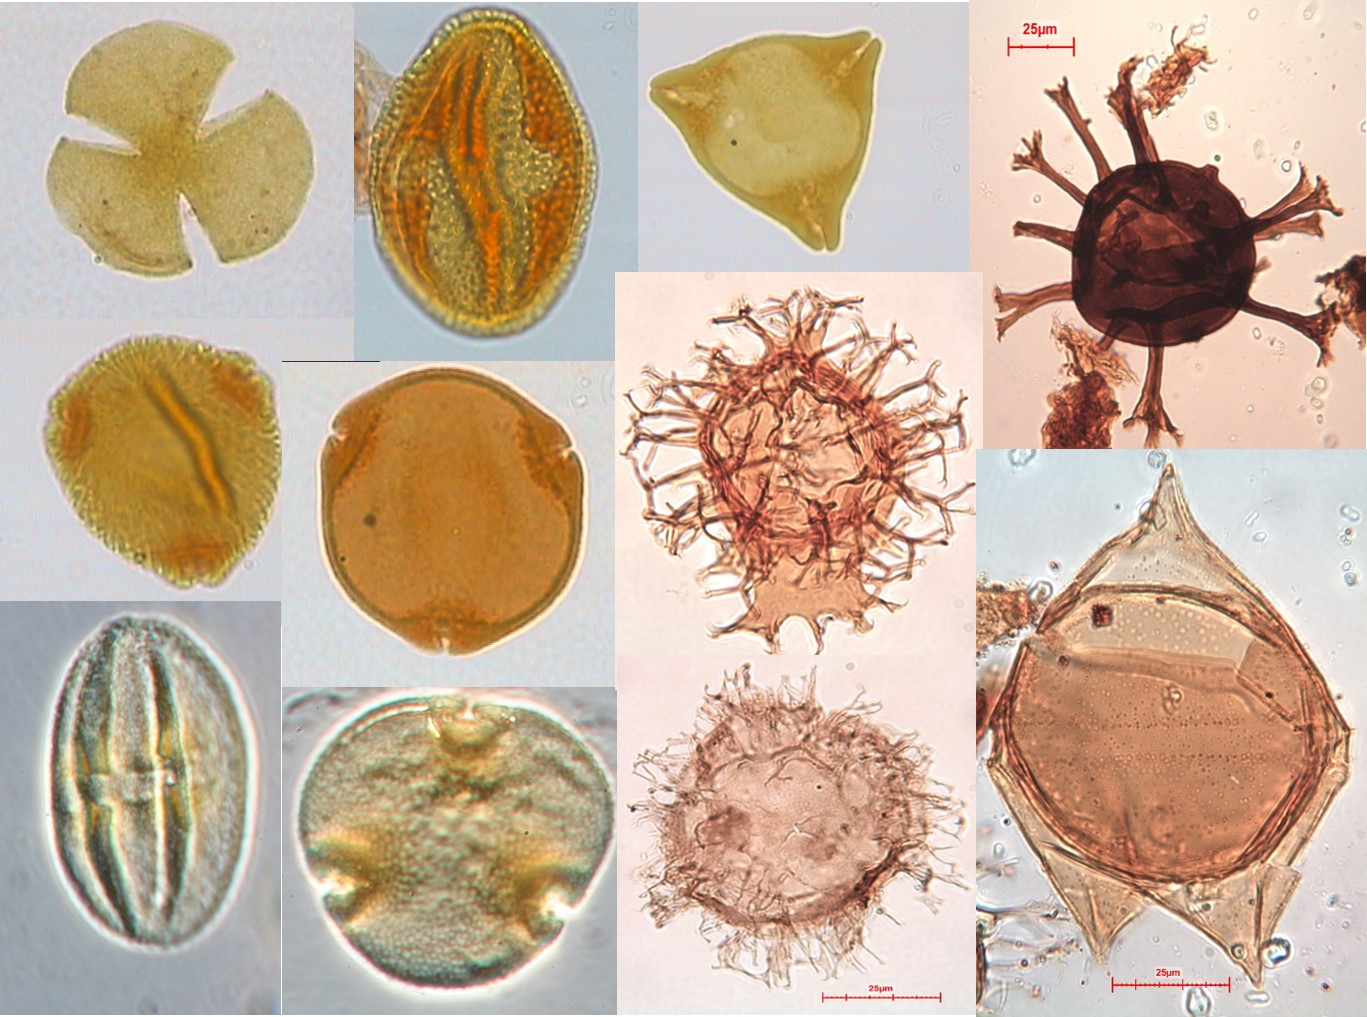

In [1]:
import pandas as pd
import numpy as np

#Plotting libraries and other types
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker
import seaborn as sns
from matplotlib import gridspec
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.externals import joblib
from sklearn import preprocessing

#Analytical libraries
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

from sklearn import tree
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, classification_report, silhouette_samples, roc_curve, roc_auc_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


#Mute warning messages: If errors occur, hash-out this import
import warnings; warnings.simplefilter('ignore')

%matplotlib inline

# Load data

In [28]:
df = pd.read_csv('sel_than_onshore.csv').drop('Unnamed: 0', axis=1) #Master df of major taxonomic groups
df.head()

,P_REGION,AREA,LAT,LONG,AGE,STAGE,GRP,ZONE,SUBZONE,TOP,...,Rhoipites capax-latus,Rhoipites cryptoporus,Spinaepollis spinosus,Tetracolporates grp.,Thomsonipollis magnificus,Triatriopollenites grp.,Ulmipollenites spp.,Normapolles (Paleocene),Symplocopollenites spp.,Tricolpites hians grp.
0,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.056433,0.138233,0.195491,0.0,0.159617,0.356915,0.000000,0.097745,0.0,0.056433
1,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.000000,0.130466,0.065233,0.0,0.112987,0.380369,0.112987,0.000000,0.0,0.065233
2,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.091670,0.158777,0.112272,0.0,0.158777,0.366679,0.091670,0.064820,0.0,0.000000
3,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.000000,0.172958,0.065372,0.0,0.269536,0.345916,0.092450,0.065372,0.0,0.000000
4,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.000000,0.202548,0.124035,0.0,0.258199,0.464095,0.000000,0.071611,0.0,0.143223


__Note__: data cleaned beforehand in a confidential notebook. It contains sensitive information relating to age of rocks and assemblages.

In [29]:
## Add a column for 'East' and 'West'
east = ['E-TX', 'LA', 'AL', 'MS']

info = df.iloc[:,:21] #split labels containing information on samples
data = df.iloc[:,21:] #the taxa count data

'''
Add a column condition based on a list to split samples into an 'East' source (i.e. Mississippi River) or a 
'West'  source (Houston embayment and Brazos River to Mexico border)
'''
info['SOURCE'] = np.where(info.REGION.isin(east),'East','West') 

df = pd.concat([info,data],sort=False, axis=1)
df.head()

,P_REGION,AREA,LAT,LONG,AGE,STAGE,GRP,ZONE,SUBZONE,TOP,...,Rhoipites capax-latus,Rhoipites cryptoporus,Spinaepollis spinosus,Tetracolporates grp.,Thomsonipollis magnificus,Triatriopollenites grp.,Ulmipollenites spp.,Normapolles (Paleocene),Symplocopollenites spp.,Tricolpites hians grp.
0,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.056433,0.138233,0.195491,0.0,0.159617,0.356915,0.000000,0.097745,0.0,0.056433
1,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.000000,0.130466,0.065233,0.0,0.112987,0.380369,0.112987,0.000000,0.0,0.065233
2,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.091670,0.158777,0.112272,0.0,0.158777,0.366679,0.091670,0.064820,0.0,0.000000
3,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.000000,0.172958,0.065372,0.0,0.269536,0.345916,0.092450,0.065372,0.0,0.000000
4,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.000000,0.202548,0.124035,0.0,0.258199,0.464095,0.000000,0.071611,0.0,0.143223


In [31]:
## Cut columns that are not in the Paleocene/ Drop columns of caved taxa
df.drop(['Annona foveoreticulata.',
               'Engelhardtioidites spp.',
               'Intratriporopollenites instructus',
               'Ilexpollenites grp.',
               'Intratriporopollenites cf instructus',
               'Juglanspollenites grp.',
               'Lanagiopollis (Eocene) grp.',
               'Quercoidites',
               'Retistephanocolporites',
               'Rhoipites capax-latus',
               'Tetracolporates grp.'], axis=1,inplace=True)


In [33]:
list(df.columns)

['P_REGION',
 'AREA',
 'LAT',
 'LONG',
 'AGE',
 'STAGE',
 'GRP',
 'ZONE',
 'SUBZONE',
 'TOP',
 'BASE',
 'TYPE',
 'ANALYST',
 'REGION',
 'LABEL',
 'SITE',
 'N',
 'S',
 'R100',
 'St dev',
 'E1/D',
 'SOURCE',
 'Freshwater algae',
 'Alnipollenites verus',
 'Baculatisporites/Osmunda grp.',
 'Bagelopollis verrucatus',
 'Bisaccates',
 'Bombacacidites spp.',
 'Brosipollis spp.',
 'Caprifoliipites viridifluminis',
 'Caryapollenites spp.',
 'Celtispollenites spp.',
 'Chenopodipollenites grp.',
 'Cicatricosisporites grp.',
 'Deltoidospora spp.',
 'Ephedra spp.',
 'Favitricolporites baculoferus',
 'Holkopollenites spp.',
 'Inaperturopollenites spp.',
 'Kyandopollenites anneratus',
 'Labrapollis globosus',
 'Laevigatosporites spp.',
 'Lanagiopollis (Paleocene)',
 'Milfordia spp.',
 'Momipites actinus grp.',
 'Momipites grp.',
 'Palms grp.',
 'Pistillipollenites mcgregorii',
 'Platycaryapollenites spp.',
 'Polypodium type',
 'Proxapertites magnus',
 'Retitrescolputes anguloluminosus',
 'Rhoipites an

In [34]:
''' 
Before splitting the data, drop any rows with low value counts (e.g PPg zones) that might not be needed for the model
'''
info = df.iloc[:,:22] #information features
data = df.iloc[:,22:] # fossil features

data.head()

,Freshwater algae,Alnipollenites verus,Baculatisporites/Osmunda grp.,Bagelopollis verrucatus,Bisaccates,Bombacacidites spp.,Brosipollis spp.,Caprifoliipites viridifluminis,Caryapollenites spp.,Celtispollenites spp.,...,Retitrescolputes anguloluminosus,Rhoipites angustus,Rhoipites cryptoporus,Spinaepollis spinosus,Thomsonipollis magnificus,Triatriopollenites grp.,Ulmipollenites spp.,Normapolles (Paleocene),Symplocopollenites spp.,Tricolpites hians grp.
0,0.079809,0.056433,0.0,0.0,0.112867,0.000000,0.0,0.0,0.314207,0.0,...,0.056433,0.000000,0.138233,0.195491,0.159617,0.356915,0.000000,0.097745,0.0,0.056433
1,0.184506,0.065233,0.0,0.0,0.235200,0.000000,0.0,0.0,0.396796,0.0,...,0.000000,0.130466,0.130466,0.065233,0.112987,0.380369,0.112987,0.000000,0.0,0.065233
2,0.242536,0.112272,0.0,0.0,0.204980,0.000000,0.0,0.0,0.444386,0.0,...,0.129641,0.091670,0.158777,0.112272,0.158777,0.366679,0.091670,0.064820,0.0,0.000000
3,0.092450,0.113228,0.0,0.0,0.206725,0.000000,0.0,0.0,0.369800,0.0,...,0.092450,0.092450,0.172958,0.065372,0.269536,0.345916,0.092450,0.065372,0.0,0.000000
4,0.143223,0.124035,0.0,0.0,0.226455,0.071611,0.0,0.0,0.189466,0.0,...,0.101274,0.160128,0.202548,0.124035,0.258199,0.464095,0.000000,0.071611,0.0,0.143223


In [36]:
df.REGION.unique()

array(['LA', 'E-TX', 'W-TX', 'HSTN', 'MS', 'C-TX', 'AL'], dtype=object)

In [7]:
## Convert the regions into numeric for modeling
le = preprocessing.LabelEncoder()
le.fit(df['SOURCE'])

#View the labels
list(le.classes_)

['East', 'West']

In [38]:
# Apply the fitted encoder to the pandas column
df['Y'] = le.transform(df['SOURCE'])
#list(le.inverse_transform([2, 2, 1]))
df.head()

,P_REGION,AREA,LAT,LONG,AGE,STAGE,GRP,ZONE,SUBZONE,TOP,...,Rhoipites angustus,Rhoipites cryptoporus,Spinaepollis spinosus,Thomsonipollis magnificus,Triatriopollenites grp.,Ulmipollenites spp.,Normapolles (Paleocene),Symplocopollenites spp.,Tricolpites hians grp.,Y
0,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.000000,0.138233,0.195491,0.159617,0.356915,0.000000,0.097745,0.0,0.056433,0
1,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.130466,0.130466,0.065233,0.112987,0.380369,0.112987,0.000000,0.0,0.065233,0
2,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.091670,0.158777,0.112272,0.158777,0.366679,0.091670,0.064820,0.0,0.000000,0
3,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.092450,0.172958,0.065372,0.269536,0.345916,0.092450,0.065372,0.0,0.000000,0
4,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,PPg5cii,0.0,...,0.160128,0.202548,0.124035,0.258199,0.464095,0.000000,0.071611,0.0,0.143223,0


In [39]:
##Move the Y columns to the front. Need to do this in 2 stages

# get a list of columns
cols = list(df)

# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('SOURCE')))
df = df.loc[:, cols]

In [40]:
cols = list(df)

## move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('Y')))
df = df.loc[:, cols]

In [44]:
## Check columns
df.columns[:23]

Index(['Y', 'SOURCE', 'P_REGION', 'AREA', 'LAT', 'LONG', 'AGE', 'STAGE', 'GRP',
       'ZONE', 'SUBZONE', 'TOP', 'BASE', 'TYPE', 'ANALYST', 'REGION', 'LABEL',
       'SITE', 'N', 'S', 'R100', 'St dev', 'E1/D', 'Freshwater algae'],
      dtype='object')

In [153]:
## To convert labelencoder back to categorical variables:
# df['Y_back'] = le.inverse_transform(df['Y']) 

In [45]:
#Save cleaned onshore and ofshore dataframes for quicker access
df.to_csv('Nonprop_onshore_cleaned_selandian_thanetian.csv')

### Split data in test and train

Note: Since these are count data and are transformed using Hellinger that works on a row by row basis (i.e. by sample), the preprocessing stage has already been undertaken and does not lead to data leakage.

__Reload data__ Sometimes this is necessary to avoid indexing issues and errors. No idea why. It's a pandas thing.

In [2]:
df = pd.read_csv('Nonprop_onshore_cleaned_selandian_thanetian.csv').drop('Unnamed: 0', axis=1)
df.head()

,Y,SOURCE,P_REGION,AREA,LAT,LONG,AGE,STAGE,GRP,ZONE,...,Retitrescolputes anguloluminosus,Rhoipites angustus,Rhoipites cryptoporus,Spinaepollis spinosus,Thomsonipollis magnificus,Triatriopollenites grp.,Ulmipollenites spp.,Normapolles (Paleocene),Symplocopollenites spp.,Tricolpites hians grp.
0,0,East,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,...,0.056433,0.000000,0.138233,0.195491,0.159617,0.356915,0.000000,0.097745,0.0,0.056433
1,0,East,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,...,0.000000,0.130466,0.130466,0.065233,0.112987,0.380369,0.112987,0.000000,0.0,0.065233
2,0,East,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,...,0.129641,0.091670,0.158777,0.112272,0.158777,0.366679,0.091670,0.064820,0.0,0.000000
3,0,East,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,...,0.092450,0.092450,0.172958,0.065372,0.269536,0.345916,0.092450,0.065372,0.0,0.000000
4,0,East,ONSHORE,LA,31.32648,-91.77235,Late_Paleocene,Thanetian,Wilcox,PPg5,...,0.101274,0.160128,0.202548,0.124035,0.258199,0.464095,0.000000,0.071611,0.0,0.143223


In [3]:
# list(df.columns[23:])
X = df.iloc[:,23:] #split training data
Y = df['Y'] #Y for classifying

In [4]:
X_train, x_test, Y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=46, stratify=Y)

print('Y_train labels:\n\n{}'.format(Y_train.value_counts().sort_index()))
print('\ny_test labels:\n\n{}'.format(y_test.value_counts().sort_index()))

Y_train labels:

0    190
1    203
Name: Y, dtype: int64

y_test labels:

0    63
1    68
Name: Y, dtype: int64


In [5]:
'''
If you want to try random oversampling. try this step. Using synthetic over-sampling 
by K-means distance
'''
sample_sizes = {0:500,
               1:500}

smote = SMOTE(sampling_strategy=sample_sizes,k_neighbors=3, random_state=46) #use defaults again.
X_sm, y_sm = smote.fit_sample(X_train, Y_train)

from collections import Counter
print('\nOriginal data: \n',sorted(Counter(Y).items()))
print('SMOTE data: \n', sorted(Counter(y_sm).items()))


Original data: 
 [(0, 253), (1, 271)]
SMOTE data: 
 [(0, 500), (1, 500)]


In [8]:
##Generate a list of labels for the heatmaps (these are sorted alphabetically, so sort them here)
labels = list(le.classes_)
print(labels)

['East', 'West']


# Naive Bayes

In [9]:
## Fonts for plotting
sns.set(style="ticks", font = 'arial')
a_font = {'fontname':'Arial'}#use to change font
itals = {'fontstyle':'italic'}

## plt.rcdefaults() #returns to plt defaults

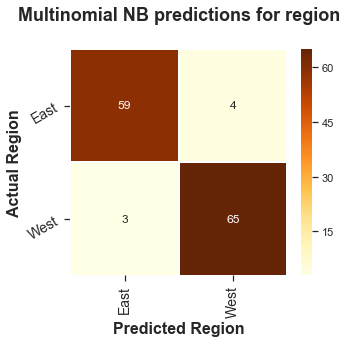

In [10]:
'''
NAIVE BAYES
'''

nb = MultinomialNB()

nb.fit(X_sm, y_sm)# (X_train, Y_train)
y_pred = nb.predict(x_test)
conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5,5))

plt.subplot(1,1,1)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr', 
                 xticklabels=labels, yticklabels=labels)
ax.set_ylabel('Actual Region', fontsize=16, weight='bold')
ax.set_xlabel('Predicted Region', fontsize=16, weight='bold')
ax.set_title('Multinomial NB predictions for region', fontsize=18, weight='bold',y=1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=30)
ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()
# plt.savefig('NB_Selandian_Thanetian_groups_confusion_matrix.png',dpi=100,bbox_inches='tight', transparent=True)


In [60]:
'''
Calculate precision and recall of model
'''
print('Classification report for NB of oversampled data:\n')
print(classification_report(y_test, y_pred, target_names=labels))


Classification report for NB of oversampled data:

              precision    recall  f1-score   support

        East       0.95      0.94      0.94        63
        West       0.94      0.96      0.95        68

   micro avg       0.95      0.95      0.95       131
   macro avg       0.95      0.95      0.95       131
weighted avg       0.95      0.95      0.95       131



# Logistic regression

In [26]:
'''
Tune the Logistic regression.
'''

param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100],
             'penalty':['l1','l2']}
#do in a log series (a convention).NB: Changing penalties doesn't alter CV score.

grid = GridSearchCV(LogisticRegression(solver='liblinear'),
                    param_grid, cv=5, n_jobs=2, scoring='f1_weighted')
grid.fit(X_sm, y_sm)#(X_train,Y_train)

print('Best cross-validation score LR: {:.2f}'.format(grid.best_score_))
print('Best parameters LR: ', grid.best_params_)

Best cross-validation score LR: 0.98
Best parameters LR:  {'C': 100, 'penalty': 'l2'}


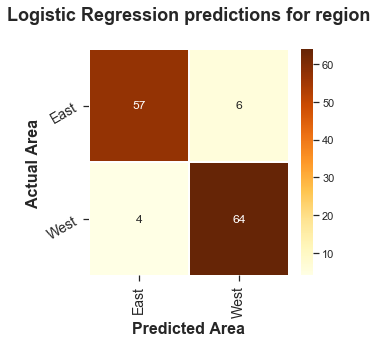

In [11]:
lr = LogisticRegression(solver='liblinear', 
                        penalty='l2',
                        C=100,
                        random_state=46)
lr.fit(X_sm, y_sm)#(X_train, Y_train)
y_pred = lr.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5,5))

plt.subplot(1,1,1)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                xticklabels=labels)
ax.set_ylabel('Actual Area', fontsize=16, weight='bold')
ax.set_xlabel('Predicted Area', fontsize=16, weight='bold')
ax.set_title('Logistic Regression predictions for region', fontsize=18, weight='bold',y=1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_xticklabels(),rotation=30)
ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()
# plt.savefig('LR_Selandian_Thanetian_groups_confusion_matrix.png',dpi=100,bbox_inches='tight', transparent=True)

In [12]:
'''
Calculate precision and recall of model
'''
print('Classification report for LR of oversampled data:\n')
print(classification_report(y_test, y_pred, target_names=labels))


Classification report for LR of oversampled data:

              precision    recall  f1-score   support

        East       0.93      0.90      0.92        63
        West       0.91      0.94      0.93        68

   micro avg       0.92      0.92      0.92       131
   macro avg       0.92      0.92      0.92       131
weighted avg       0.92      0.92      0.92       131



# SVM

In [29]:
'''
Tune the SVM
'''
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10],
             'gamma': [0.001,0.01, 0.1, 1, 10],
             'kernel': ['rbf', 'linear', 'poly']}

grid = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=2, scoring='f1_weighted')
grid.fit(X_sm, y_sm) #(X_train,Y_train)

print('Best cross-validation score SVC: {:.2f}'.format(grid.best_score_))
print('Best parameters SVC: ', grid.best_params_)

Best cross-validation score SVC: 1.00
Best parameters SVC:  {'C': 1, 'gamma': 10, 'kernel': 'rbf'}


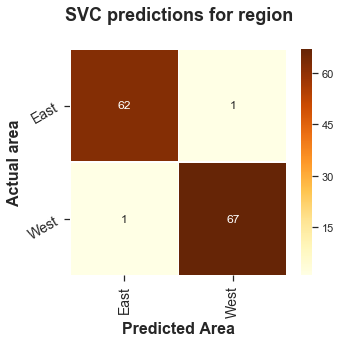

In [13]:
svc = SVC(kernel='rbf', 
         C=1,
         gamma=10,
         random_state=46,
         probability=True) #set probability to True to get predict_probab()

svc.fit(X_sm, y_sm) #(X_train, Y_train)
y_pred = svc.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5,5))

plt.subplot(111)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                xticklabels=labels)
ax.set_ylabel('Actual area', fontsize=16, weight='bold')
ax.set_xlabel('Predicted Area', fontsize=16, weight='bold')
ax.set_title('SVC predictions for region', fontsize=18, weight='bold', y=1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_xticklabels(),rotation=30)
ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()
# plt.savefig('SVC_Selandian_Thanetian_groups_confusion_matrix.png',dpi=100,bbox_inches='tight', transparent=True)

In [66]:
'''
Calculate precision and recall of model
'''
print('Classification report for SVM of oversampled data:\n')
print(classification_report(y_test, y_pred, target_names=labels))

Classification report for SVM of oversampled data:

              precision    recall  f1-score   support

        East       0.98      0.98      0.98        63
        West       0.99      0.99      0.99        68

   micro avg       0.98      0.98      0.98       131
   macro avg       0.98      0.98      0.98       131
weighted avg       0.98      0.98      0.98       131



# Random Forest Classifier

In [32]:
'''
Tune the Random forest classifier
'''
##Tune parameters for Random Forest Classifier
param_grid = {'n_estimators':[100, 150,250,300], #Last iteration of grid.
             'max_depth': [50, 60, 70, 80]}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=2, scoring='f1_weighted')
grid.fit(X_sm, y_sm) #(X_train,Y_train)

print('Best cross-validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters: ', grid.best_params_)

Best cross-validation score: 0.99
Best parameters:  {'max_depth': 60, 'n_estimators': 300}


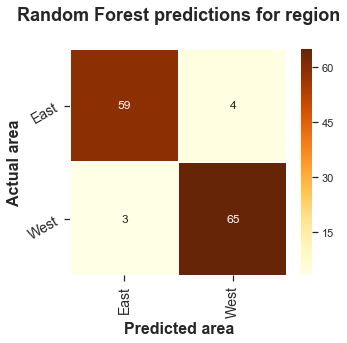

In [14]:
rfc = RandomForestClassifier(n_estimators = 300, 
                             max_depth = 60, 
                             class_weight='balanced_subsample',
                             random_state=46) 
rfc.fit(X_sm, y_sm)#(X_train, Y_train)
y_pred = rfc.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5,5))

plt.subplot(111)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                xticklabels=labels)
ax.set_ylabel('Actual area', fontsize=16, weight='bold')
ax.set_xlabel('Predicted area', fontsize=16, weight='bold')
ax.set_title('Random Forest predictions for region', fontsize=18, weight='bold', y=1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_xticklabels(),rotation=30)
ax.tick_params(labelsize=14)


plt.tight_layout()
plt.show()
# plt.savefig('RFC_Selandian_Thanetian_groups_confusion_matrix.png',dpi=100,bbox_inches='tight', transparent=True)

In [15]:
'''
Calculate precision and recall of model
'''
print('Classification report for RFC of oversampled data:\n')
print(classification_report(y_test, y_pred, target_names=labels))

Classification report for RFC of oversampled data:

              precision    recall  f1-score   support

        East       0.95      0.94      0.94        63
        West       0.94      0.96      0.95        68

   micro avg       0.95      0.95      0.95       131
   macro avg       0.95      0.95      0.95       131
weighted avg       0.95      0.95      0.95       131



# AdaBoost

In [35]:
'''
Tune the AdaBoost classifier
'''
##Tune parameters for Random Forest Classifier
param_grid = {'n_estimators':[100, 150,250,300, 350], #Last iteration of grid.
             'learning_rate': [0.001, 0.01, 0.1, 1]}
grid = GridSearchCV(AdaBoostClassifier(), param_grid, cv=5, n_jobs=2, scoring='f1_weighted')
grid.fit(X_sm, y_sm) #(X_train,Y_train)

print('Best cross-validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters: ', grid.best_params_)

Best cross-validation score: 0.98
Best parameters:  {'learning_rate': 1, 'n_estimators': 100}


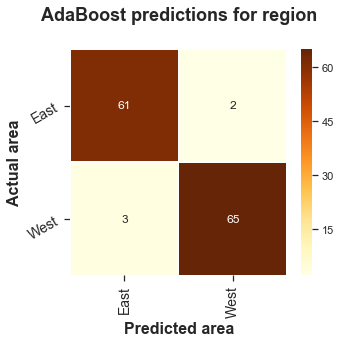

In [16]:
adc = AdaBoostClassifier(n_estimators = 100, 
                             learning_rate=1, 
                             random_state=46) 

adc.fit(X_sm, y_sm)#(X_train, Y_train)
y_pred = adc.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5,5))

plt.subplot(111)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                xticklabels=labels)
ax.set_ylabel('Actual area', fontsize=16, weight='bold')
ax.set_xlabel('Predicted area', fontsize=16, weight='bold')
ax.set_title('AdaBoost predictions for region', fontsize=18, weight='bold', y=1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_xticklabels(),rotation=30)
ax.tick_params(labelsize=14)


plt.tight_layout()
plt.show()
# plt.savefig('ABC_Selandian_Thanetian_groups_confusion_matrix.png',dpi=100,bbox_inches='tight', transparent=True)

In [72]:
'''
Calculate precision and recall of model
'''
print('Classification report for ADC of oversampled data:\n')
print(classification_report(y_test, y_pred, target_names=labels))

Classification report for ADC of oversampled data:

              precision    recall  f1-score   support

        East       0.95      0.97      0.96        63
        West       0.97      0.96      0.96        68

   micro avg       0.96      0.96      0.96       131
   macro avg       0.96      0.96      0.96       131
weighted avg       0.96      0.96      0.96       131



# KNN classifier

In [17]:
'''
Tune the KNN

The most significant tuning parameter is the number of neighbours to consider (k)
'''
training_accuracy = []
test_accuracy = []

neighbors = range(1,11,2) #use an odd number of neighbours as recommended by Albon (2018)

for n_neighbors in neighbors:
    #non oversampled data
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_sm, y_sm)#(X_train, Y_train)
    training_accuracy.append(knn.score(X_sm, y_sm))
    test_accuracy.append(knn.score(x_test, y_test))


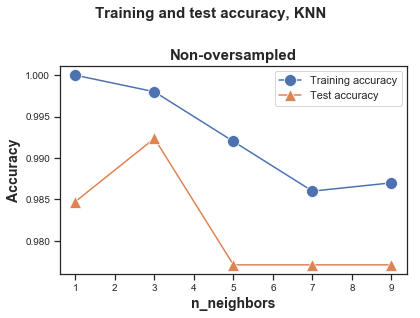

In [18]:
sns.set_style("ticks") #Shows tick marks on x and y axes.
fig, ax = plt.subplots(figsize=(6,4))

plt.subplot(111)
ax = sns.lineplot(x=neighbors, y=training_accuracy, linewidth=1.5, marker='o', ms=12)
sns.lineplot(x=neighbors, y=test_accuracy, linewidth=1.5, marker='^', ms=12)
ax.set_title('Non-oversampled', fontsize=15, weight='bold')
ax.set_ylabel('Accuracy', fontsize=14,weight='bold')
ax.set_xlabel('n_neighbors', fontsize=14, weight='bold')
ax.tick_params(labelsize=10)
ax.legend(handles=ax.lines, labels=['Training accuracy', 'Test accuracy'])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.suptitle('Training and test accuracy, KNN', fontsize=15, weight='bold', y=1.1)
plt.tight_layout()
plt.show()

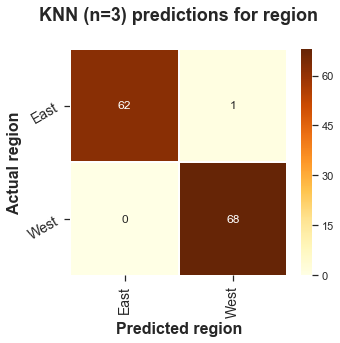

In [19]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_sm, y_sm) #(X_train, Y_train)
y_pred = knn.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5,5))

plt.subplot(111)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                xticklabels=labels)
ax.set_ylabel('Actual region', fontsize=16, weight='bold')
ax.set_xlabel('Predicted region', fontsize=16, weight='bold')
ax.set_title('KNN (n=3) predictions for region', fontsize=18, weight='bold', y=1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_xticklabels(),rotation=30)
ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()
# plt.savefig('KNN_Selandian_Thanetian_groups_confusion_matrix.png',dpi=100,bbox_inches='tight', transparent=True)

In [77]:
'''
Calculate precision and recall of model
'''
print('Classification report for KNN of raw data:\n')
print(classification_report(y_test, y_pred, target_names=labels))

Classification report for KNN of raw data:

              precision    recall  f1-score   support

        East       1.00      0.98      0.99        63
        West       0.99      1.00      0.99        68

   micro avg       0.99      0.99      0.99       131
   macro avg       0.99      0.99      0.99       131
weighted avg       0.99      0.99      0.99       131



# Ensemble model

In [20]:
'''
Use the VotingClassifier to find a stronger model based on contrasting best-tuned models. Code adapted 
from Susan Li (2018) blog post to incorporate the VotingClassifier
'''

models = [rfc, svc, lr, knn, adc, nb,
           VotingClassifier(estimators=[('RFC', rfc),('SVC', svc), ('LR', lr),('KNN', knn),('ADB', adc),('NB', nb)],
                            voting='soft')]

CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    scores = cross_val_score(model, X_train, Y_train, scoring='f1_weighted', cv=CV, n_jobs=4)
    for fold_idx, score in enumerate(scores):
        entries.append((model_name, fold_idx, score))
cv_df = pd.DataFrame(entries, columns=['model_name','fold_idx', 'f1_weighted'])

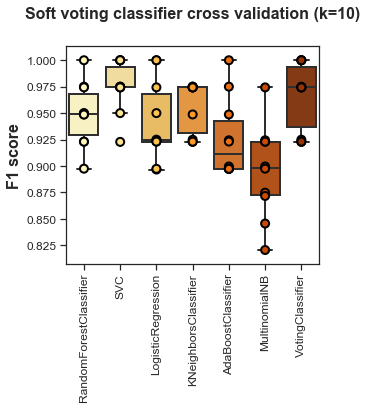

In [22]:
##Plot the results

fig, ax = plt.subplots(figsize=(10,4))
sns.set(style="ticks")

plt.subplot(121)
ax = sns.boxplot(x='model_name', y='f1_weighted', data=cv_df, palette='YlOrBr', linewidth=2)
ax = sns.stripplot(x='model_name', y='f1_weighted', data=cv_df, size=8, 
                   jitter=False, edgecolor="black",linewidth=2, palette='YlOrBr')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.axes.set_title('Soft voting classifier cross validation (k=10)',weight='bold', fontsize=16, y=1.1)
ax.set_ylabel('F1 score',fontsize=16, weight='bold')
ax.set_xlabel('')
ax.tick_params(labelsize=12)

# plt.show()
plt.savefig('VC_Selandian_Thanetian_groups_boxplots.jpeg',dpi=300,bbox_inches='tight', transparent=True)

In [23]:
##Check the accuracy of the models:

print('Median of model CVs:\n \n' + str(cv_df.groupby('model_name').f1_weighted.mean().sort_values(ascending=False)))

Median of model CVs:
 
model_name
SVC                       0.974582
VotingClassifier          0.966857
KNeighborsClassifier      0.956672
RandomForestClassifier    0.948988
LogisticRegression        0.941348
AdaBoostClassifier        0.925993
MultinomialNB             0.895394
Name: f1_weighted, dtype: float64


In [24]:
model_vc = VotingClassifier(estimators=[('RFC', rfc),('SVC', svc), ('LR', lr),('KNN', knn), ('ADB', adc), ('NB', nb)],
                            voting='soft')

model_vc.fit(X_train, Y_train)
y_pred_vc = model_vc.predict(x_test)
probabilities = model_vc.predict_proba(x_test)*100

In [25]:
probabilities[:,1]

array([14.84193633, 77.34800625, 70.93231213, 89.9667098 , 24.41154402,
       84.71925189, 20.0622361 , 14.43067101, 54.52010385, 89.15917207,
       81.75262643, 84.72557082, 19.24328986, 88.56382034, 15.29973489,
       84.19175173, 82.15039774, 17.25563019, 18.54746723, 17.28050119,
       85.29171116, 17.39789685, 56.06442217, 51.92368576, 82.0528054 ,
       15.15997596, 30.65493022, 20.47045992, 85.26399945, 85.93534038,
       87.37718931, 16.50725119, 90.04670786, 82.79018909, 87.73022943,
       50.0541171 , 85.84060121, 89.36577331, 76.43570349, 89.28916683,
       87.83035403, 17.08965332, 20.91441878, 52.54442062, 83.50004551,
       84.55814752, 88.7337625 , 87.85002908, 23.95641673, 18.05817694,
       18.31391543, 84.94233288, 89.51114338, 13.20044667, 16.4996648 ,
       16.23725497, 28.08892699, 13.68984621, 84.17086198, 31.47689159,
       83.00310308, 13.96119749, 14.28882808, 16.37429629, 89.49094736,
       84.48670077, 81.52323954, 16.62875728, 89.07266016, 32.45

## Confusion matrix and % error

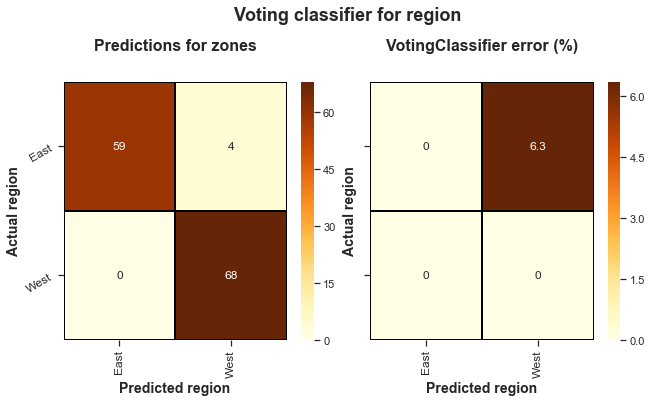

In [27]:
conf_mat_vc = confusion_matrix(y_test, y_pred_vc)
fig, ax = plt.subplots(figsize=(10.5,4.75))

plt.subplot(121)
ax = sns.heatmap(conf_mat_vc, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr', linewidth=1, linecolor='black',
                 xticklabels = labels, yticklabels=labels)
ax.set_ylabel('Actual region', fontsize=14, weight='bold')
ax.set_xlabel('Predicted region', fontsize=14, weight='bold')
ax.set_title('Predictions for zones', fontsize=16, weight='bold', y=1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_xticklabels(),rotation=30)
ax.tick_params(labelsize=12)

'''
Calculate the error rate of the voting classifier data predictions:
'''

row_sums = conf_mat_vc.sum(axis=1, keepdims=True)
norm_conf_mat = conf_mat_vc/row_sums*100

np.fill_diagonal(norm_conf_mat, 0)

plt.subplot(122)
ax = sns.heatmap(norm_conf_mat, annot=True, linewidths=0.5, cmap='YlOrBr', 
                 linewidth=1, linecolor='black',xticklabels=labels)
ax.set_ylabel('Actual region', fontsize=14, weight='bold')
ax.set_xlabel('Predicted region', fontsize=14, weight='bold')
ax.set_title('VotingClassifier error (%)', fontsize=16, weight='bold', y=1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels('')
ax.set_yticklabels('')
ax.tick_params(labelsize=12)


plt.suptitle('Voting classifier for region', fontsize=18, weight='bold',y=1.1)
plt.subplots_adjust(wspace=0.1)

# plt.savefig('Voting_classifier_soft_confusion_matrix_data_error_Sel_Than.jpeg',dpi=300,bbox_inches='tight', transparent=True)
plt.show()

## Classification report

In [28]:
'''
Calculate precision and recall of model
'''
print('Classification report for VC of raw data:\n')
print(classification_report(y_test, y_pred_vc, target_names=labels))

Classification report for VC of raw data:

              precision    recall  f1-score   support

        East       1.00      0.94      0.97        63
        West       0.94      1.00      0.97        68

   micro avg       0.97      0.97      0.97       131
   macro avg       0.97      0.97      0.97       131
weighted avg       0.97      0.97      0.97       131



## ROC 

Ideal curve is close to the top left - i.e. high recall with low false positive rate.

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities[:,1], pos_label=1)

In [30]:
# tpr.mean()
roc_auc_score(y_test, probabilities[:,1])

0.9957983193277311

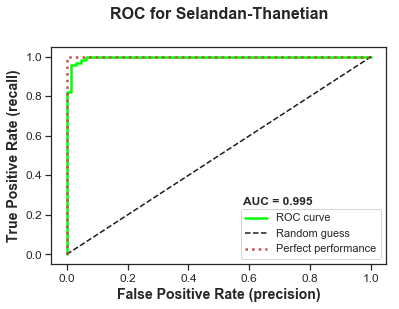

In [31]:
plt.plot(fpr, tpr, label='ROC curve', linewidth=2.5, color='#00ff00')
plt.plot([0,1],[0,1], 'k--', label='Random guess')
plt.plot([0,0,1], [0,1,1], ':', label='Perfect performance', linewidth=2.5, color='r')
plt.title('ROC for Selandan-Thanetian', fontsize=16, y=1.1, weight='bold', **a_font)
plt.xlabel('False Positive Rate (precision)', fontsize=14, weight='bold',**a_font)
plt.ylabel('True Positive Rate (recall)', fontsize=14, weight='bold', **a_font)
plt.legend(loc=4)
plt.tick_params(labelsize=12)
plt.text(0.58, 0.25, 'AUC = 0.995', fontsize=12, weight='bold', **a_font)
plt.savefig('ROC_AUC_selandian_thanetian.jpeg',dpi=300,bbox_inches='tight', transparent=True)
# plt.show()


## Caution
The models are almost certainly overfit and in most cases are isolating a handful of anomalous samples from an individual sampling site. Hence, they may not generalize to either an East or West classification. They are also time-series (or a special sort) and may vary over time within sites and especially in the Louisiana area.

## Pickle the model

In [56]:
## Pickel the model:
scikit_version = joblib.__version__

#Save model
joblib.dump(model_vc, 'VotingClassifier_GoM_region_all_grps_selandian_thanetian_{version}.pkl'.format(version=scikit_version))

['VotingClassifier_GoM_region_all_grps_selandian_thanetian_0.13.0.pkl']

# Fit against offshore data

## Reload offshore data and split

In [2]:
# Load offshore data if necessary
df_offshore = pd.read_csv('sel_than_offshore.csv').drop('Unnamed: 0', axis=1) #Offshore data of same age and with identical columns.
df_offshore.head()

,P_REGION,AREA,LAT,LONG,AGE,STAGE,GRP,ZONE,SUBZONE,TOP,...,Rhoipites capax-latus,Rhoipites cryptoporus,Spinaepollis spinosus,Tetracolporates grp.,Thomsonipollis magnificus,Triatriopollenites grp.,Ulmipollenites spp.,Normapolles (Paleocene),Symplocopollenites spp.,Tricolpites hians grp.
0,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33350.0,...,0.0,0.0,0.000000,0.0,0.249351,0.176318,0.0,0.000000,0.000000,0.0
1,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33380.0,...,0.0,0.0,0.000000,0.0,0.176227,0.294884,0.0,0.000000,0.078811,0.0
2,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33410.0,...,0.0,0.0,0.071247,0.0,0.236300,0.174519,0.0,0.071247,0.000000,0.0
3,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33440.0,...,0.0,0.0,0.000000,0.0,0.233762,0.147844,0.0,0.073922,0.000000,0.0
4,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33470.0,...,0.0,0.0,0.000000,0.0,0.294392,0.200000,0.0,0.081650,0.000000,0.0


In [3]:
list(df_offshore.columns)

['P_REGION',
 'AREA',
 'LAT',
 'LONG',
 'AGE',
 'STAGE',
 'GRP',
 'ZONE',
 'SUBZONE',
 'TOP',
 'BASE',
 'TYPE',
 'ANALYST',
 'REGION',
 'LABEL',
 'SITE',
 'N',
 'S',
 'R100',
 'St dev',
 'E1/D',
 'Freshwater algae',
 'Alnipollenites verus',
 'Annona foveoreticulata.',
 'Baculatisporites/Osmunda grp.',
 'Bagelopollis verrucatus',
 'Bisaccates',
 'Bombacacidites spp.',
 'Brosipollis spp.',
 'Caprifoliipites viridifluminis',
 'Caryapollenites spp.',
 'Celtispollenites spp.',
 'Chenopodipollenites grp.',
 'Cicatricosisporites grp.',
 'Deltoidospora spp.',
 'Engelhardtioidites spp.',
 'Ephedra spp.',
 'Favitricolporites baculoferus',
 'Holkopollenites spp.',
 'Intratriporopollenites instructus',
 'Ilexpollenites grp.',
 'Inaperturopollenites spp.',
 'Intratriporopollenites cf instructus',
 'Juglanspollenites grp.',
 'Kyandopollenites anneratus',
 'Labrapollis globosus',
 'Laevigatosporites spp.',
 'Lanagiopollis (Paleocene)',
 'Lanagiopollis (Eocene) grp.',
 'Milfordia spp.',
 'Momipites ac

In [5]:
## Cut columns that are not in the Paleocene/ Drop columns of caved taxa
df_offshore.drop(['Annona foveoreticulata.',
               'Engelhardtioidites spp.',
               'Intratriporopollenites instructus',
               'Ilexpollenites grp.',
               'Intratriporopollenites cf instructus',
               'Juglanspollenites grp.',
               'Lanagiopollis (Eocene) grp.',
               'Quercoidites',
               'Retistephanocolporites',
               'Rhoipites capax-latus',
               'Tetracolporates grp.'], axis=1,inplace=True)

In [96]:
sel_than_off = df_offshore
sel_than_off.shape

(1502, 60)

In [9]:
# list(sel_than_off.columns[21:])
X_off = sel_than_off.iloc[:,21:]

## SVM against offshore data

In [101]:
y_pred_off = svc.predict(X_off)
probabilities = svc.predict_proba(X_off)*100

In [102]:
sel_than_off['Predictions_SVC'] = le.inverse_transform(y_pred_off)
sel_than_off.tail()

,P_REGION,AREA,LAT,LONG,AGE,STAGE,GRP,ZONE,SUBZONE,TOP,...,Spinaepollis spinosus,Thomsonipollis magnificus,Triatriopollenites grp.,Ulmipollenites spp.,Normapolles (Paleocene),Symplocopollenites spp.,Tricolpites hians grp.,Predictions_KNN,Predictions_NB,Predictions_SVC
1497,OFFSHORE,Walker Ridge,26.872536,-91.573569,Middle Paleocene,Selandian,Wilcox,PPg3,PPg3b,33180.0,...,0.0,0.340693,0.267261,0.133631,0.188982,0.0,0.094491,East,West,East
1498,OFFSHORE,Walker Ridge,26.872536,-91.573569,Middle Paleocene,Selandian,Wilcox,PPg3,PPg3a,33240.0,...,0.0,0.282843,0.219089,0.000000,0.089443,0.0,0.126491,West,West,West
1499,OFFSHORE,Walker Ridge,26.872536,-91.573569,Middle Paleocene,Selandian,Wilcox,PPg3,PPg3a,33300.0,...,0.0,0.165900,0.000000,0.000000,0.095783,0.0,0.000000,West,West,West
1500,OFFSHORE,Walker Ridge,26.872536,-91.573569,Middle Paleocene,Selandian,Wilcox,PPg3,PPg3a,33350.0,...,0.0,0.236801,0.193347,0.000000,0.000000,0.0,0.136717,East,East,West
1501,OFFSHORE,Walker Ridge,26.872536,-91.573569,Middle Paleocene,Selandian,Wilcox,PPg3,PPg3a,33410.0,...,0.0,0.189832,0.134231,0.000000,0.094916,0.0,0.000000,West,West,East


## KNN against offshore data

In [97]:
y_pred_off = knn.predict(X_off)
probabilities = knn.predict_proba(X_off)*100

In [98]:
sel_than_off['Predictions_KNN'] = le.inverse_transform(y_pred_off)
sel_than_off.tail()

,P_REGION,AREA,LAT,LONG,AGE,STAGE,GRP,ZONE,SUBZONE,TOP,...,Rhoipites angustus,Rhoipites cryptoporus,Spinaepollis spinosus,Thomsonipollis magnificus,Triatriopollenites grp.,Ulmipollenites spp.,Normapolles (Paleocene),Symplocopollenites spp.,Tricolpites hians grp.,Predictions_KNN
1497,OFFSHORE,Walker Ridge,26.872536,-91.573569,Middle Paleocene,Selandian,Wilcox,PPg3,PPg3b,33180.0,...,0.000000,0.094491,0.0,0.340693,0.267261,0.133631,0.188982,0.0,0.094491,East
1498,OFFSHORE,Walker Ridge,26.872536,-91.573569,Middle Paleocene,Selandian,Wilcox,PPg3,PPg3a,33240.0,...,0.000000,0.089443,0.0,0.282843,0.219089,0.000000,0.089443,0.0,0.126491,West
1499,OFFSHORE,Walker Ridge,26.872536,-91.573569,Middle Paleocene,Selandian,Wilcox,PPg3,PPg3a,33300.0,...,0.095783,0.095783,0.0,0.165900,0.000000,0.000000,0.095783,0.0,0.000000,West
1500,OFFSHORE,Walker Ridge,26.872536,-91.573569,Middle Paleocene,Selandian,Wilcox,PPg3,PPg3a,33350.0,...,0.000000,0.096674,0.0,0.236801,0.193347,0.000000,0.000000,0.0,0.136717,East
1501,OFFSHORE,Walker Ridge,26.872536,-91.573569,Middle Paleocene,Selandian,Wilcox,PPg3,PPg3a,33410.0,...,0.094916,0.000000,0.0,0.189832,0.134231,0.000000,0.094916,0.0,0.000000,West


## Naive Bayes

In [99]:
y_pred_off = nb.predict(X_off)
probabilities = nb.predict_proba(X_off)*100

In [100]:
sel_than_off['Predictions_NB'] = le.inverse_transform(y_pred_off)
sel_than_off.tail()

,P_REGION,AREA,LAT,LONG,AGE,STAGE,GRP,ZONE,SUBZONE,TOP,...,Rhoipites cryptoporus,Spinaepollis spinosus,Thomsonipollis magnificus,Triatriopollenites grp.,Ulmipollenites spp.,Normapolles (Paleocene),Symplocopollenites spp.,Tricolpites hians grp.,Predictions_KNN,Predictions_NB
1497,OFFSHORE,Walker Ridge,26.872536,-91.573569,Middle Paleocene,Selandian,Wilcox,PPg3,PPg3b,33180.0,...,0.094491,0.0,0.340693,0.267261,0.133631,0.188982,0.0,0.094491,East,West
1498,OFFSHORE,Walker Ridge,26.872536,-91.573569,Middle Paleocene,Selandian,Wilcox,PPg3,PPg3a,33240.0,...,0.089443,0.0,0.282843,0.219089,0.000000,0.089443,0.0,0.126491,West,West
1499,OFFSHORE,Walker Ridge,26.872536,-91.573569,Middle Paleocene,Selandian,Wilcox,PPg3,PPg3a,33300.0,...,0.095783,0.0,0.165900,0.000000,0.000000,0.095783,0.0,0.000000,West,West
1500,OFFSHORE,Walker Ridge,26.872536,-91.573569,Middle Paleocene,Selandian,Wilcox,PPg3,PPg3a,33350.0,...,0.096674,0.0,0.236801,0.193347,0.000000,0.000000,0.0,0.136717,East,East
1501,OFFSHORE,Walker Ridge,26.872536,-91.573569,Middle Paleocene,Selandian,Wilcox,PPg3,PPg3a,33410.0,...,0.000000,0.0,0.189832,0.134231,0.000000,0.094916,0.0,0.000000,West,West


## Fit against offshore data

If re-running the trained ensemble model, load the libraries (top of notebook), then load the offshore data (10, Reload offshore data and split), import the pickled model and run code below.

In [103]:
## Import pickled ensemble model
clf = joblib.load('VotingClassifier_GoM_areas_terrestrial_palaeoenvironments_0.13.0.pkl')

In [104]:
y_pred_off = model_vc.predict(X_off)
probabilities = model_vc.predict_proba(X_off)*100

In [105]:
sel_than_off['Predictions_VC'] = le.inverse_transform(y_pred_off)
# sel_than_off['Probabilities'] = probabilities
sel_than_off.tail()

,P_REGION,AREA,LAT,LONG,AGE,STAGE,GRP,ZONE,SUBZONE,TOP,...,Thomsonipollis magnificus,Triatriopollenites grp.,Ulmipollenites spp.,Normapolles (Paleocene),Symplocopollenites spp.,Tricolpites hians grp.,Predictions_KNN,Predictions_NB,Predictions_SVC,Predictions_VC
1497,OFFSHORE,Walker Ridge,26.872536,-91.573569,Middle Paleocene,Selandian,Wilcox,PPg3,PPg3b,33180.0,...,0.340693,0.267261,0.133631,0.188982,0.0,0.094491,East,West,East,West
1498,OFFSHORE,Walker Ridge,26.872536,-91.573569,Middle Paleocene,Selandian,Wilcox,PPg3,PPg3a,33240.0,...,0.282843,0.219089,0.000000,0.089443,0.0,0.126491,West,West,West,West
1499,OFFSHORE,Walker Ridge,26.872536,-91.573569,Middle Paleocene,Selandian,Wilcox,PPg3,PPg3a,33300.0,...,0.165900,0.000000,0.000000,0.095783,0.0,0.000000,West,West,West,West
1500,OFFSHORE,Walker Ridge,26.872536,-91.573569,Middle Paleocene,Selandian,Wilcox,PPg3,PPg3a,33350.0,...,0.236801,0.193347,0.000000,0.000000,0.0,0.136717,East,East,West,West
1501,OFFSHORE,Walker Ridge,26.872536,-91.573569,Middle Paleocene,Selandian,Wilcox,PPg3,PPg3a,33410.0,...,0.189832,0.134231,0.000000,0.094916,0.0,0.000000,West,West,East,West


In [106]:
list(clf.classes_)

[0, 1]

In [107]:
## Extract relevant predictions. There are 2 for the classes. Make into columns of the info df

sel_than_off['EAST'] = probabilities[:,0]
sel_than_off['WEST'] = probabilities[:,1]

In [108]:
## Sort by site and by base so each site is in stratigraphic order
sel_than_off = sel_than_off.sort_values(['SITE', 'BASE'], ascending=[True, True])
sel_than_off.to_csv('Selandian_Thanetian_offshore_probabilities_groups.csv')

In [109]:
sel_than_off.head()

,P_REGION,AREA,LAT,LONG,AGE,STAGE,GRP,ZONE,SUBZONE,TOP,...,Ulmipollenites spp.,Normapolles (Paleocene),Symplocopollenites spp.,Tricolpites hians grp.,Predictions_KNN,Predictions_NB,Predictions_SVC,Predictions_VC,EAST,WEST
0,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33350.0,...,0.0,0.000000,0.000000,0.0,East,West,East,East,61.192575,38.807425
1,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33380.0,...,0.0,0.000000,0.078811,0.0,East,West,East,West,39.484166,60.515834
2,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33410.0,...,0.0,0.071247,0.000000,0.0,West,West,East,West,37.561620,62.438380
3,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33440.0,...,0.0,0.073922,0.000000,0.0,West,West,West,West,20.630470,79.369530
4,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33470.0,...,0.0,0.081650,0.000000,0.0,West,West,East,West,32.991702,67.008298


## Aggregate the median values for each well and export
Predictions are aggregated so they can be plotted as single points on a map. Clearly, they are time-series and may change from west-east or east-west at different times.

In [2]:
sel_than_off = pd.read_csv('Selandian_Thanetian_offshore_probabilities_groups.csv').drop('Unnamed: 0', axis=1)
sel_than_off.head()

,P_REGION,AREA,LAT,LONG,AGE,STAGE,GRP,ZONE,SUBZONE,TOP,...,Ulmipollenites spp.,Normapolles (Paleocene),Symplocopollenites spp.,Tricolpites hians grp.,Predictions_KNN,Predictions_NB,Predictions_SVC,Predictions_VC,EAST,WEST
0,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33350.0,...,0.0,0.000000,0.000000,0.0,East,West,East,East,61.192575,38.807425
1,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33380.0,...,0.0,0.000000,0.078811,0.0,East,West,East,West,39.484166,60.515834
2,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33410.0,...,0.0,0.071247,0.000000,0.0,West,West,East,West,37.561620,62.438380
3,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33440.0,...,0.0,0.073922,0.000000,0.0,West,West,West,West,20.630470,79.369530
4,OFFSHORE,Keathley Canyon,26.812689,-92.431457,Late Paleocene,Thanetian,Wilcox,PPg5,PPg5d,33470.0,...,0.0,0.081650,0.000000,0.0,West,West,East,West,32.991702,67.008298


In [30]:
## Get probabilities of east and west for all onshore Selandian-Thanetian data:
# west_probs_vc = sel_than_off.groupby(['SITE','LAT','LONG','REGION'])['WEST'].agg(['size','mean',np.std])

# ## Save as csv
# west_probs_vc.to_csv('Sel_than_offshore_group_probabilities_VC.csv')

## reimport csv and insert the headers
# west_probs_vc = pd.read_csv('Sel_than_offshore_group_probabilities_VC.csv')
# west_probs_vc.columns = ['SITE','LAT','LONG','REGION','SIZE','MEAN', 'STDEV']

## Save all probabilities
west_probs_vc.to_csv('Sel_than_offshore_group_probabilities_VC.csv')

In [29]:
west_probs_vc

,SITE,LAT,LONG,REGION,SIZE,MEAN,STDEV
0,AEGEAN,26.812689,-92.431457,0,45,44.780495,16.518195
1,ARDENNES,26.313646,-92.097007,0,111,68.523067,12.907618
2,BIOKO,26.313646,-92.097007,0,37,51.624177,16.898991
3,BLACKTIP,0.000000,0.000000,0,81,72.447032,14.878575
4,BLACKTIP_ST,0.000000,0.000000,0,74,75.725507,12.598131
5,CASCADE,26.733803,-90.490171,0,41,58.321472,17.726387
6,CHINOOK,26.516008,-90.540722,0,49,26.416787,9.083296
7,COBRA,26.155936,-95.020059,0,40,66.550429,12.619062
8,CORONADO,26.853803,-91.435461,0,90,35.079731,17.359919
9,DAMASCUS,26.380293,-91.483004,0,36,21.583618,9.573198
